# K-Means and Gaussian Mixture Models

## Proposed Method

We will first use the k-means clustering algorithm to produce the mean values that we will use to initialize our GMMs, followed by Expectation Maximization to calculate the covariances of the GMMs.

## Step 0: Data Preparation and Exploration

After importing our basic utility libraries and dataset, we plot our data to get an understanding of what kind of models we should be working with. 

We will first work with the Synthetic data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
INF = 99999999
train_data = np.loadtxt("Synthetic/train.txt",delimiter=",")
train_data_classes = np.asarray([train_data[np.where(train_data[:,2]==i)] for i in [1,2]])

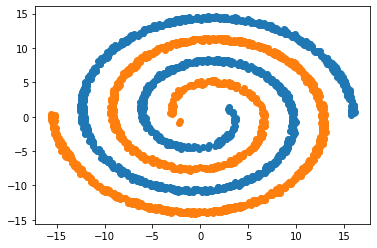

In [3]:
plt.scatter(train_data_classes[0,:,0],train_data_classes[0,:,1])
plt.scatter(train_data_classes[1,:,0],train_data_classes[1,:,1])
plt.show()

As we can clearly see above, using k-means clustering on this dataset with 2 clusters will yield disastrous results.

Hence, we will instead use k-means to initialize our mean positions and then utilize them to generate GMMs.

## Step 1: Implementing $k$-means clustering

This step is slightly complex, so reading through the comments will be more useful to follow along.

We essentially make use of numpy broadcasting and indexing to vectorize our entire operation which speeds it up tremendously. 

Vectorization enables our code to be generalized to work with any $d$ dimensional dataset, with any choice of $k$, and any dataset size $n$. The only thing required is for each data example to be provided in the form `[x1, x2, x3, ... xn, class]`

In [4]:
def k_means(data,k=15,iters=100):
    # reshape data for numpy broadcasting
    data = np.reshape(data,[-1,1,data.shape[-1]])
    # initialize k means with random means
    myrange = np.linspace(0,data.shape[0]-1,k,dtype = np.int64)
    kmeans = np.vstack([data[myrange,0,i] for i in range(0,data.shape[-1])]).T
    # reshape data for numpy broadcasting
    kmeans = np.reshape(kmeans,[1,-1,kmeans.shape[-1]])
    # calculate distances with some broadcasting magic
    dists = np.sqrt(np.sum((data - kmeans)**2,axis=2))
    # initialize cluster assignments
    
    # choose n rows from a kxk identity matrix 
    # using an nx1 argmin matrix (ranging from 0 to k-1)
    # to produce an nxk 1-hot encoded matrix
    r_nk_old = np.eye(k)[np.argmin(dists,axis=1)]
    r_nk_new = r_nk_old.copy()
    c = 0
    while True:
        #print(f"Iteration {c}")
        c+=1
        # move cluster assignments into old variable for comparison
        r_nk_old = r_nk_new.copy()
        # update means
        if np.any(np.sum(r_nk_old,axis=0) == 0):
            print(r_nk_old)
            print("error, 0 sum encountered")
            break
        kmeans = (r_nk_old.T @ np.squeeze(data))/np.reshape(np.sum(r_nk_old,axis=0),[-1,1])
        # update new cluster assignments
        dists = np.sqrt(np.sum((data - kmeans)**2,axis=2))
        r_nk_new = np.eye(k)[np.argmin(dists,axis=1)]
        # test for convergence
        if np.all(r_nk_old == r_nk_new) or iters == c:
            break
    print(f"Iterations to convergence = {c}")
    return kmeans, r_nk_new

Now we will see what kind of means we have got from this, and whether we should use more or less complex values of $k$.

Iterations to convergence = 33
Iterations to convergence = 18


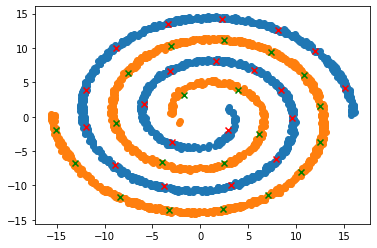

In [5]:
k = 20
plt.figure()
cls = [1,2]
cl_to_ind = {1:0, 2:1}
cl_colors = ['r','g']
means_kmeans_d = {}
allots_kmeans_d = {}
for cl in cls:
    means_here,allotments_here = k_means(train_data_classes[cl_to_ind[cl],:,:-1], k)
    means_kmeans_d[cl], allots_kmeans_d[cl] = means_here, allotments_here
    plt.scatter(train_data_classes[cl_to_ind[cl],:,0],train_data_classes[cl_to_ind[cl],:,1])
    plt.scatter(means_here[:,0],means_here[:,1],c=cl_colors[cl_to_ind[cl]],marker='x')
plt.show()

In [6]:
means_kmeans_d[1].shape

(20, 2)

## What happens when we use other values of $k$

### Larger values of $k$

This is expected to be more accurate and closely fit the data, but will make our GMM covariance calculation step extremely lengthy.

As seen above, too large a value of $k$, while being extremely accurate, is not necessary as there are too many cluster centers in a very small region, which is unnecessary and will slow us down tremendously while calculating the GMM covariances.

### Smaller values of $k$

This is expected to too inaccurate to fit the data, and may actually yield worse performance than baseline (<50%) but will make our GMM covariance calculation step much faster.

As clearly seen above, the cluster centers for too small a value of $k$ leads to the means being in the totally opposite distribution, which would actually give us worse performance than a baseline of 50%

## Expectation Maximization for Gaussian Mixtures

We start by creating a function to calculate the gaussian probability distribution for a given dataset, its mean and its covariance.
Note that since we calculate an inverse, this slows down our code tremendously.


We also create a function to calculate the covariance for given data, but this function is only used once.

In [7]:
from scipy.stats import multivariate_normal as muno

def gaussian1(x,mean,cov):
    mean = np.reshape(mean[:-1],[1,-1])
    x_mu = np.squeeze(x - mean)
    D = x_mu.shape[-1]
    covinv = np.linalg.pinv(cov)
    #print(f"x_mu {x_mu.shape}, covinv: {covinv.shape}")
    n_n = 1/(2*np.pi)**(D/2) / np.linalg.det(cov)**(1/2) * np.exp(-0.5 * x_mu @ covinv @ x_mu.T)
    return np.diagonal(n_n)

def gaussian2(X, mu, sigma):
    X = np.array(X)
    if len(X.shape) == 1:
        X = np.reshape(X, [1] + list(X.shape))
    sigma = np.reshape(sigma, [1]+list(sigma.shape))
    det = np.linalg.det(sigma)
    const = 1.0/ (np.power((2*np.pi), float(len(mu))/2) * np.power(det, 1.0/2))
    diff = X - mu
    sigma_inv = np.linalg.inv(sigma)
    result = np.exp(-0.5*np.einsum('ik,kl,il->i', diff, sigma_inv[0], diff))
    return const * result

def gaussian(X, mu, sigma):
    return gaussian2(X, mu, sigma)

def gaussian3(x,mean,cov):
    D = len(mean)
    x_mu = x-mean
    covinv = np.linalg.pinv(cov)
    return (1/((2*np.pi)**(D/2) * np.linalg.det(cov)**(0.5))) * np.exp(-0.5 * (x_mu @ covinv @ x_mu.T))

def cov(data):
    N = data.shape[0]
    # part 1: calculating means
    means = np.squeeze(np.sum(data,axis=0))/data.shape[0]
    # part 2: calculating covariances
    x = np.squeeze(data)
    covs = ((x - means).T @ (x - means))/(N-1)
    return covs

The $\pi_k$ matrix is initialized with values from the k-means estimate:

$$\pi_k = \frac{N_k}{N}$$

The covariances are initialized using the covariance function we created above, and the data is reshaped in order to allow easy numpy broadcasting.

We then calculate the initial value of the log likelihood as:

$$\sum_{n=1}^{N}\ln \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x_n}|\mathbf{\mu_k,\Sigma_k}) \right)$$

After this, we perform the E and M steps as detailed in Bishop.

We check if the new and old log likelihoods are different by more than $10^{-6}$ as our convergence criterion.

**Note:** We have aimed to vectorize the code as much as possible, and hence don't use many `for-loops` in the code. Many operations are done over the entire 

In [8]:
print(gaussian(np.array([[1,1],[2,2]]), np.array([1,1]), np.array([[1,0], [0,1]])))

[0.15915494 0.05854983]


In [9]:
def EM(data,means,allotments, iters=100, mean_update=True, diag=False):
    
    # Iteration counter
    ct = 0

    # calculate the number of points allotted to each cluster
    Nk = np.sum(allotments,axis=0)
    Nk = np.reshape(Nk,[-1,1])
    
    # initialize pi_k
    N = data.shape[0]
    pi_k = Nk/N
    
    # find  k
    k = means.shape[0]
    D = data.shape[-1]

    # create x without the classes of data:
    x = data
    
    # initialize cov_k
    if diag:
        cov_k = (1e-6 * np.eye(D)) + np.array([cov(x)*np.eye(D)]*k)
    else:
        cov_k = (1e-6 * np.eye(data.shape[1])) + np.array([cov(x)]*k)
    
    
    # initialize log likelihood
    ll_old = -INF
    
    while True:
        ct += 1
        # E Step:
        deno_g = np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]) for j in range(k)],axis=0).reshape([1,-1])
        gammas = np.array([pi_k[i] * gaussian(x,means[i],cov_k[i]) for i in range(k)]) / deno_g
        
        # M Step:
        Nk = np.sum(gammas,axis=1).reshape([-1,1])

        if mean_update:
            means = np.array([(1/Nk[k_ind])*np.sum([gammas[k_ind][n_ind]*x[n_ind] for n_ind in range(x.shape[0])], axis=0) for k_ind in range(Nk.shape[0])])
        
        cov_k = (1e-6 * np.eye(data.shape[1])) + np.array([(1/Nk[k_ind])*np.sum([gammas[k_ind][n_ind]*(x[n_ind]-means[k_ind]).reshape([-1,1]) @ (x[n_ind]-means[k_ind]).reshape([-1,1]).T for n_ind in range(x.shape[0])], axis=0) for k_ind in range(Nk.shape[0])])
        if diag:
            cov_k = cov_k * np.eye(D)
        
        pi_k = Nk/N

        # Compute Likelihood again
        try:
            if diag:
                ll_new = np.sum(np.log(np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]*np.eye(D)) for j in range(k)], axis=1)))
            else:
                ll_new = np.sum(np.log(np.sum([pi_k[j] * gaussian(x,means[j],cov_k[j]) for j in range(k)], axis=1)))
        except:
            print("Linalg error, mostly singular matrix")
            print("Cov_k:\n", cov_k)
            print([np.linalg.det(cov_k[k_ind]) for k_ind in range(Nk.shape[0])])
            break
        #print(f"iter {ct}, ll_new: {ll_new}")

        # Termination condition
        if np.abs(ll_new - ll_old) < 1e-6 or ll_new < ll_old or ct == iters:
            break

        ll_old = ll_new.copy()
    print("Iterations taken:", ct)
    return means,cov_k,pi_k

def roc_det(posts_ll, cases, pr_type='', algo='', extra='', skip=1):

    # Plot ROC for select k
    fig1, ax1 = plt.subplots(figsize=[10,10])
    fig2, ax2 = plt.subplots(figsize=[10,10])

    # Sort in ascending order
    for c_id in range(len(cases)):
        posts_list = posts_ll[cases[c_id]]
        posts_list = sorted(posts_list)
        tp_fn_cts = [0]  #  tp_fn_cts[i] = no. of examples left of (and excluding) i which can be only tp or fn
        tn_fp_cts = [0]

        for i in range(len(posts_list)):
            post_here = posts_list[i]
            if post_here[1] == post_here[2]:
                tp_fn_cts.append(tp_fn_cts[-1] + 1)
                tn_fp_cts.append(tn_fp_cts[-1])
            else:
                tp_fn_cts.append(tp_fn_cts[-1])
                tn_fp_cts.append(tn_fp_cts[-1] + 1)

        # print(tp_fn_cts)
        # print(tn_fp_cts)
        tp_fn_tot = tp_fn_cts[-1]
        tn_fp_tot = tn_fp_cts[-1]
        tpr = []
        fpr = []
        tnr = []
        fnr = []
        
        for i in range(len(posts_list)):

            thresh = posts_list[i][0]
            tpr.append((tp_fn_tot - tp_fn_cts[i])/tp_fn_tot)
            fpr.append((tn_fp_tot - tn_fp_cts[i])/tn_fp_tot)
            tnr.append(tn_fp_cts[i]/tn_fp_tot)
            fnr.append(tp_fn_cts[i]/tp_fn_tot)

        # roc_pts = [[fpr[i],tpr[i]] for i in range(len(tpr))]
        if c_id%skip == 0:
            ax1.plot(fpr, tpr)
            ax2.plot(fpr, fnr)
    ax1.legend(cases[::skip])
    ax2.legend(cases[::skip])
    ax1.set_xlabel('False Positive Rate (FPR)')
    ax1.set_ylabel('True Positive Rate (TPR)')

    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('False Negative Rate (FNR)')

    ax2.set_xscale('logit')
    ax2.set_yscale('logit')

    # scale = 2
    # ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))
    # ax2.xaxis.set_major_formatter(ticks)
    # ax2.yaxis.set_major_formatter(ticks)

    ax1.set_title(f"ROC Curves {pr_type} {algo} {extra}")
    ax2.set_title(f"DET Curves {pr_type} {algo} {extra}")

    fig1.savefig(f"./Plots/ROC_{pr_type}_{algo}_{extra}.png")
    fig2.savefig(f"./Plots/DET_{pr_type}_{algo}_{extra}.png")
    plt.show()

In [10]:
k

20

In [11]:
means_em_d = {}
covs_em_d = {}
pi_em_d = {}
for cl in cls:
    means_em_d[cl], covs_em_d[cl], pi_em_d[cl] = EM(train_data_classes[cl_to_ind[cl],:,:-1],means_kmeans_d[cl],allots_kmeans_d[cl], mean_update=False)

Iterations taken: 82
Iterations taken: 17


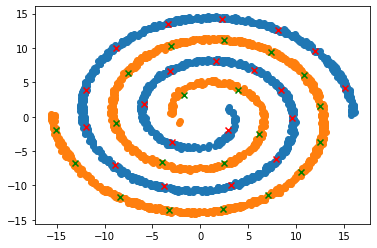

In [12]:
plt.figure()
for cl in cls:
    plt.scatter(train_data_classes[cl_to_ind[cl],:,0],train_data_classes[cl_to_ind[cl],:,1])
    plt.scatter(means_em_d[cl][:,0],means_em_d[cl][:,1],c=cl_colors[cl_to_ind[cl]],marker='x')
plt.show()

In [13]:
# predict(x, pdfs)

def predict(x, means, covs, pis, iters=30):
    classes = sorted(list(means.keys()))
    cl_prob_d = {}
    for cl in classes:
        k = len(means[cl])
        cl_prob = 0
        for kk in range(k):
            cl_prob += gaussian(x,means[cl][kk],covs[cl][kk])*pis[cl][kk]
        cl_prob_d[cl] = cl_prob
    
    denom = sum([cl_prob_d[cl] for cl in classes])
    posts = {cl:cl_prob_d[cl]/denom for cl in classes}
    pred_cl = max(posts, key=posts.get)
    return pred_cl, posts

In [14]:
x1_pts = np.linspace(-20, 20, 200)
x2_pts = np.linspace(-20, 20, 200)
x1_mesh, x2_mesh = np.meshgrid(x1_pts, x2_pts)
ij_pts = np.array([np.array([i,j]) for i,j in zip(np.ravel(x1_mesh), np.ravel(x2_mesh))])

In [15]:
k

20

Starting class 1 ...
Mixture 2 plotted
Mixture 3 plotted
Mixture 4 plotted
Mixture 5 plotted
Mixture 6 plotted
Mixture 7 plotted
Mixture 8 plotted
Mixture 9 plotted
Mixture 10 plotted
Mixture 11 plotted
Mixture 12 plotted
Mixture 13 plotted
Mixture 14 plotted
Mixture 15 plotted
Mixture 16 plotted
Mixture 17 plotted
Mixture 18 plotted
Mixture 19 plotted
Mixture 20 plotted
Starting class 2 ...
Mixture 2 plotted
Mixture 3 plotted
Mixture 4 plotted
Mixture 5 plotted
Mixture 6 plotted
Mixture 7 plotted
Mixture 8 plotted
Mixture 9 plotted
Mixture 10 plotted
Mixture 11 plotted
Mixture 12 plotted
Mixture 13 plotted
Mixture 14 plotted
Mixture 15 plotted
Mixture 16 plotted
Mixture 17 plotted
Mixture 18 plotted
Mixture 19 plotted
Mixture 20 plotted


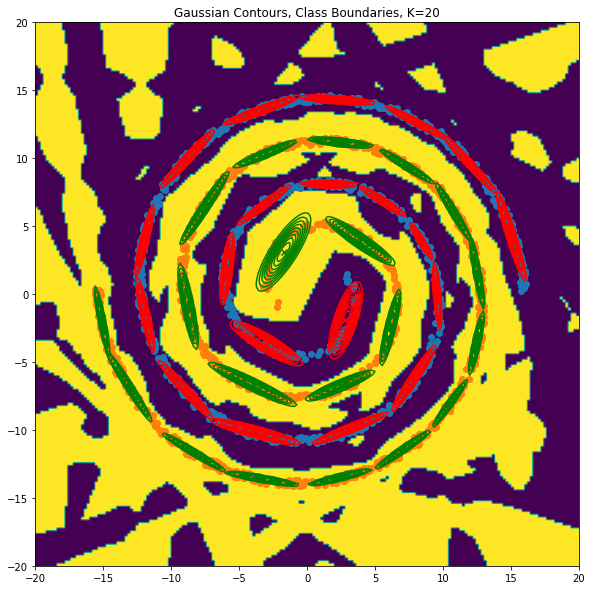

In [16]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca()
for cl in cls:
    print(f"Starting class {cl} ...")
    
    # zk_pts = np.array([gaussian(np.array([i,j]), means_em_d[cl][0], covs_em_d[cl][0]) for i,j in zip(np.ravel(x1_mesh), np.ravel(x2_mesh))])
    zk_pts = np.array(gaussian(ij_pts, means_em_d[cl][0], covs_em_d[cl][0]))
    zk_mesh = zk_pts.reshape(x1_mesh.shape)
    lev_ct = 5

    ax = fig.gca()
    cset = ax.contour(x1_mesh, x2_mesh, zk_mesh, colors=cl_colors[cl_to_ind[cl]], levels = np.linspace(np.max(zk_mesh)/4,np.max(zk_mesh), 10)) #levels = np.linspace(np.max(zk_mesh)/1.5,np.max(zk_mesh), 10)
    for kk in range(1,k):
        # print(f"means_em_d shape: {means_em_d[cl].shape}")
        # zk_pts = np.array([gaussian(np.array([i,j]), means_em_d[cl][kk], covs_em_d[cl][kk]) for i,j in zip(np.ravel(x1_mesh), np.ravel(x2_mesh))])
        zk_pts = np.array(gaussian(ij_pts, means_em_d[cl][kk], covs_em_d[cl][kk]))
        zk_mesh = zk_pts.reshape(x1_mesh.shape)

        
        ax = fig.gca()
        cset = ax.contour(x1_mesh, x2_mesh, zk_mesh, colors=cl_colors[cl_to_ind[cl]], levels = np.linspace(np.max(zk_mesh)/4,np.max(zk_mesh), 10))
        # z_pts += zk_pts
        print(f'Mixture {kk+1} plotted')
    plt.scatter(train_data_classes[cl_to_ind[cl],:,0],train_data_classes[cl_to_ind[cl],:,1])
    plt.scatter(means_em_d[cl][:,0],means_em_d[cl][:,1],c=cl_colors[cl_to_ind[cl]],marker='x')

class_pts = np.array([predict([i,j], means_em_d, covs_em_d, pi_em_d)[0] for i,j in zip(np.ravel(x1_mesh), np.ravel(x2_mesh))])
class_mesh = class_pts.reshape(x1_mesh.shape)
ax=fig.gca()
ax.imshow(np.rot90(np.fliplr(class_mesh),2), extent=[-20, 20, -20, 20], cmap='viridis')
    # z_mesh = z_pts.reshape(x1_mesh.shape)
plt.title(f"Gaussian Contours, Class Boundaries, K={k}")
plt.savefig(f"./Plots/contours_synth_k_{k}")
plt.show()

In [17]:
#predict(x=train_data_classes[:,:,:-1],means=means_em_d,covs=covs_em_d)
cl_rando, posts_rando = predict([2.5,0], means_em_d, covs_em_d, pi_em_d)
print(cl_rando, posts_rando)

1 {1: array([1.]), 2: array([3.53024897e-17])}


In [18]:
# Run on Dev data
dev_data = np.loadtxt("Synthetic/dev.txt",delimiter=",")
dev_feats = dev_data[:,:2]
dev_true_cl = dev_data[:,2]
correct = 0
total = 0
for i in range(dev_feats.shape[0]):
    pred_cl, posts = predict(dev_feats[i],means_em_d, covs_em_d, pi_em_d)
    true_cl = dev_true_cl[i]
    if pred_cl == dev_true_cl[i]:
        correct += 1
    total += 1
acc = correct/total
print(f"Acc: {acc}")

Acc: 1.0


In [33]:
def acc_post(data, k_range, do_plot = False, diag=False, iters = 100):
    diag_str = 'diag' if diag else 'full'
    acc = {}
    posts_ll_full = {}
    for k in k_range:
        posts_list_full_k = []
        print(f"k={k}")
        cls_k = [1,2]
        cl_to_ind = {1:0, 2:1}
        cl_colors = ['red', 'green']
        means_kmeans_d_k = {}
        allots_kmeans_d_k = {}
        for cl in cls_k:
            means_here,allotments_here = k_means(data[cl_to_ind[cl],:,:-1], k, iters=iters)
            means_kmeans_d_k[cl], allots_kmeans_d_k[cl] = means_here, allotments_here
        means_em_d_k = {}
        covs_em_d_k = {}
        pi_em_d_k = {}
        for cl in cls_k:
            means_em_d_k[cl], covs_em_d_k[cl], pi_em_d_k[cl] = EM(data[cl_to_ind[cl],:,:-1],means_kmeans_d_k[cl],allots_kmeans_d_k[cl], mean_update=False, diag=diag, iters=iters)
        correct = 0
        total = 0
        for i in range(dev_feats.shape[0]):
            pred_cl, posts_here = predict(dev_feats[i],means_em_d_k, covs_em_d_k, pi_em_d_k)
            true_cl = dev_true_cl[i]
            posts_list_full_k.extend([[posts_here[j_cl], j_cl, true_cl] for j_cl in cls])
            if pred_cl == dev_true_cl[i]:
                correct += 1
            total += 1
        acc[k] = correct/total
        print(f"Accuracy: {acc[k]}")
        if do_plot:
            fig = plt.figure(figsize=[10,10])
            x1_pts = np.linspace(-20, 20, 200)
            x2_pts = np.linspace(-20, 20, 200)
            x1_mesh, x2_mesh = np.meshgrid(x1_pts, x2_pts)
            ij_pts = np.array([np.array([i,j]) for i,j in zip(np.ravel(x1_mesh), np.ravel(x2_mesh))])
            for cl in cls_k:
                print(f"Starting class {cl} ...")
                
                zk_pts = np.array(gaussian(ij_pts, means_em_d_k[cl][0], covs_em_d[cl][0]))
                zk_mesh = zk_pts.reshape(x1_mesh.shape)
                lev_ct = 4

                ax = fig.gca()
                cset = ax.contour(x1_mesh, x2_mesh, zk_mesh, colors=cl_colors[cl_to_ind[cl]], levels = np.linspace(np.max(zk_mesh)/lev_ct,np.max(zk_mesh), 10))
                for kk in range(1,k):
                    zk_pts = np.array(gaussian(ij_pts, means_em_d_k[cl][kk], covs_em_d_k[cl][kk]))
                    zk_mesh = zk_pts.reshape(x1_mesh.shape)
                    
                    ax = fig.gca()
                    cset = ax.contour(x1_mesh, x2_mesh, zk_mesh, colors=cl_colors[cl_to_ind[cl]], levels = np.linspace(np.max(zk_mesh)/lev_ct,np.max(zk_mesh), 10))
                    #print(f'Mixture {kk+1} plotted')
                plt.scatter(data[cl_to_ind[cl],:,0],data[cl_to_ind[cl],:,1])
                plt.scatter(means_em_d_k[cl][:,0],means_em_d_k[cl][:,1],c=cl_colors[cl_to_ind[cl]],marker='x')
            ax=fig.gca()
            plt.title(f"Mixture Contours synth {k}-means {diag_str} cov, {iters} iterations")
            plt.savefig(f"Plots/{k}_synth_means_{diag_str}_{iters}.png")
            plt.show()
        posts_ll_full[k] = posts_list_full_k
    return acc, posts_ll_full

k=18
Iterations to convergence = 10
Iterations to convergence = 10
Iterations taken: 10
Iterations taken: 10
Accuracy: 0.936
Starting class 1 ...
Starting class 2 ...


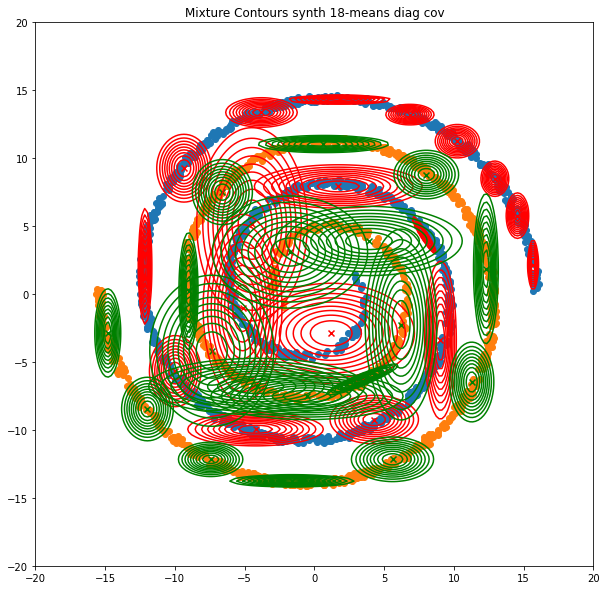

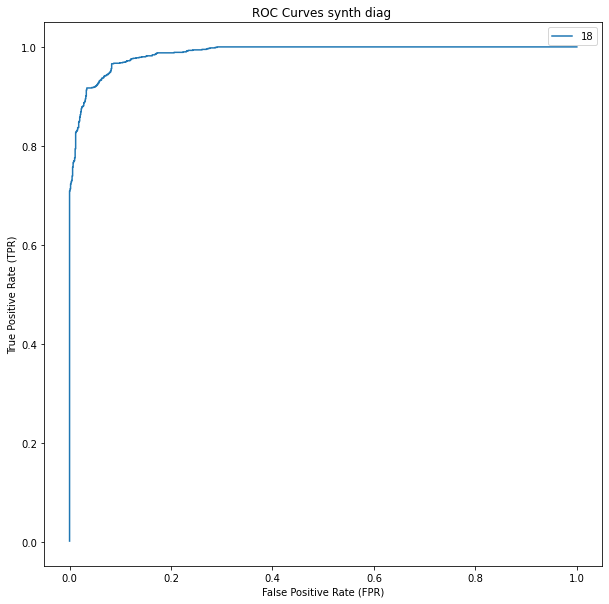

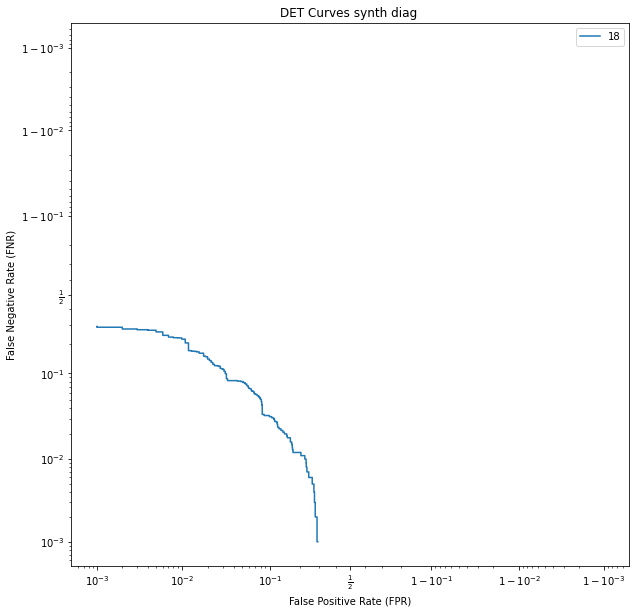

k=18
Iterations to convergence = 10
Iterations to convergence = 10
Iterations taken: 10
Iterations taken: 10
Accuracy: 0.999
Starting class 1 ...
Starting class 2 ...


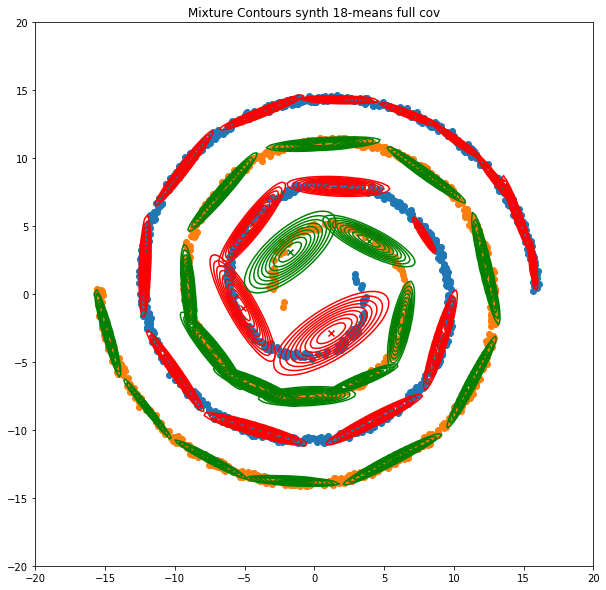

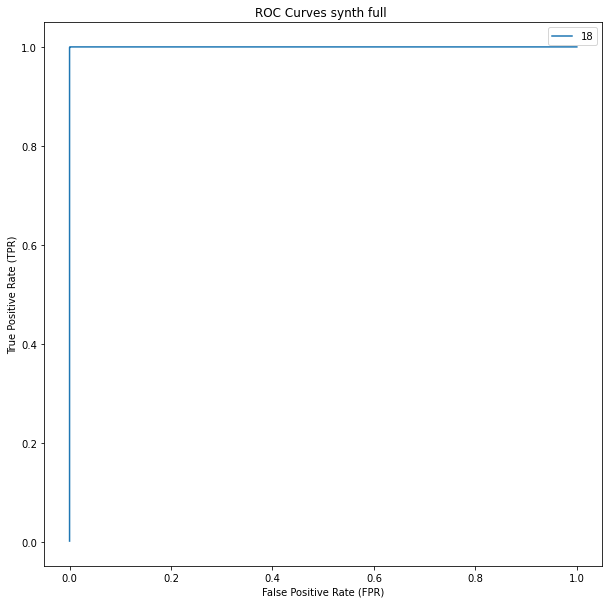

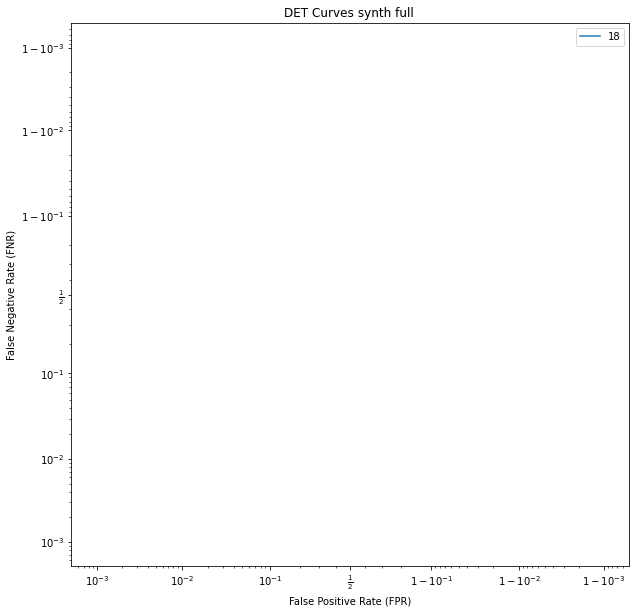

k=18
Iterations to convergence = 24
Iterations to convergence = 30
Iterations taken: 23
Iterations taken: 30
Accuracy: 0.981
Starting class 1 ...
Starting class 2 ...


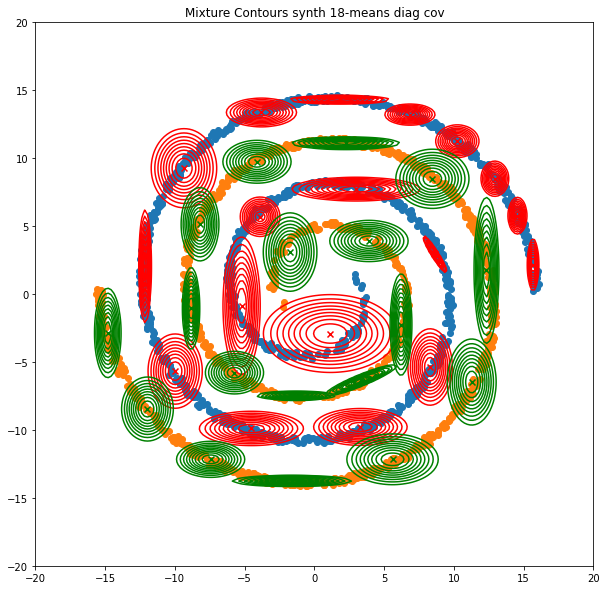

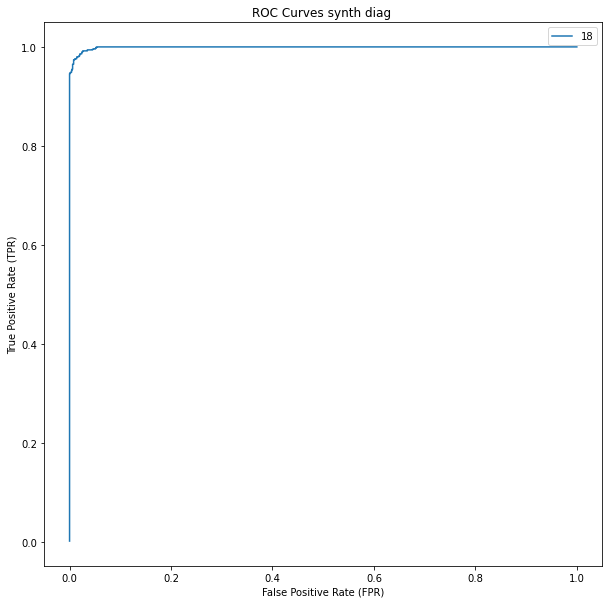

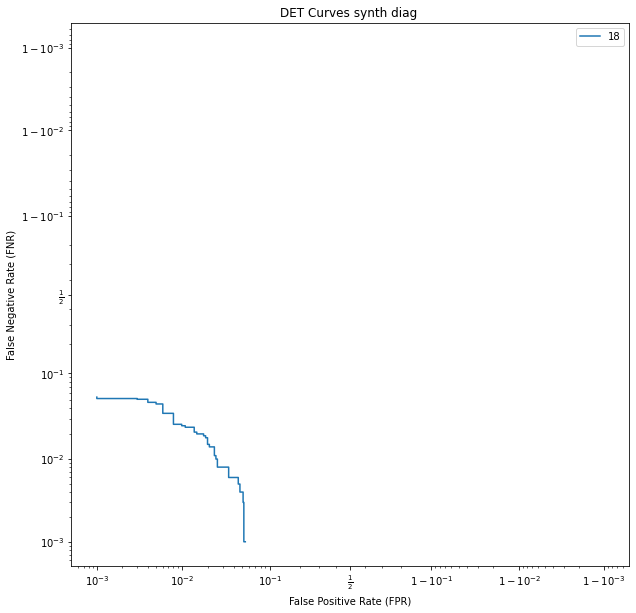

k=18
Iterations to convergence = 24
Iterations to convergence = 30
Iterations taken: 30
Iterations taken: 30
Accuracy: 0.999
Starting class 1 ...
Starting class 2 ...


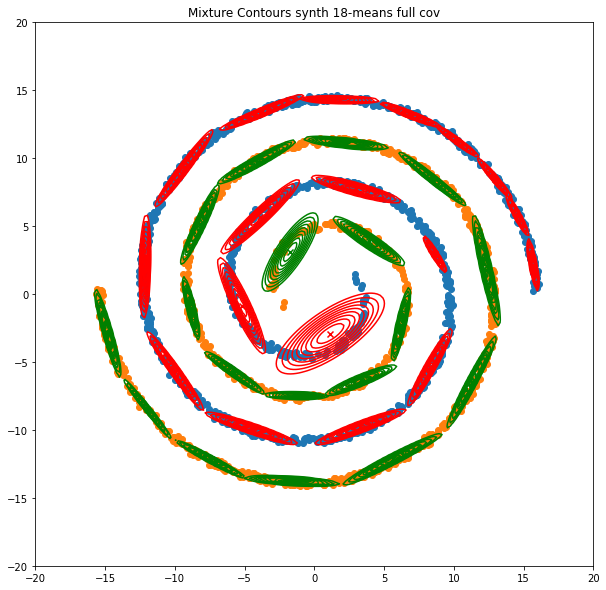

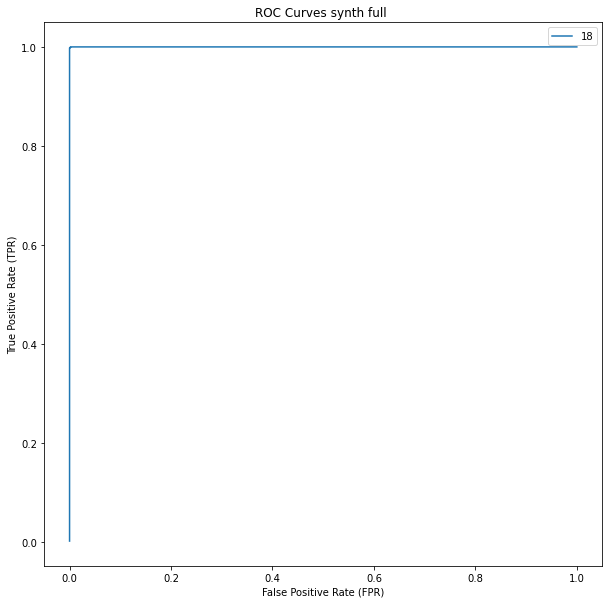

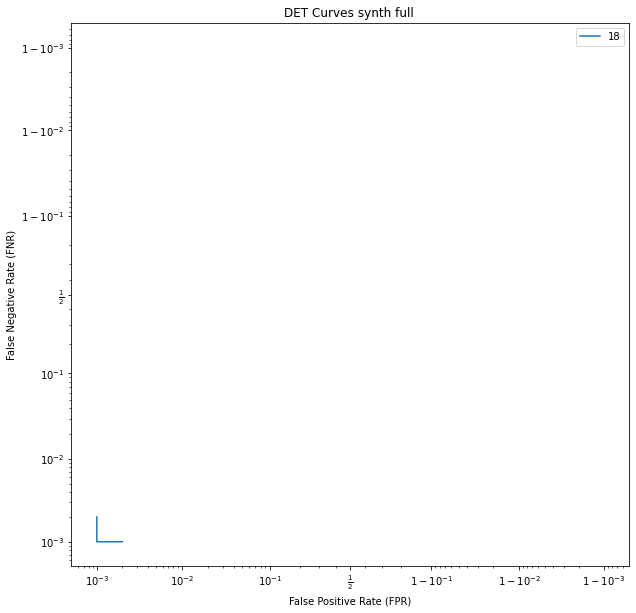

k=18
Iterations to convergence = 24
Iterations to convergence = 43
Iterations taken: 23
Iterations taken: 50
Accuracy: 0.98
Starting class 1 ...
Starting class 2 ...


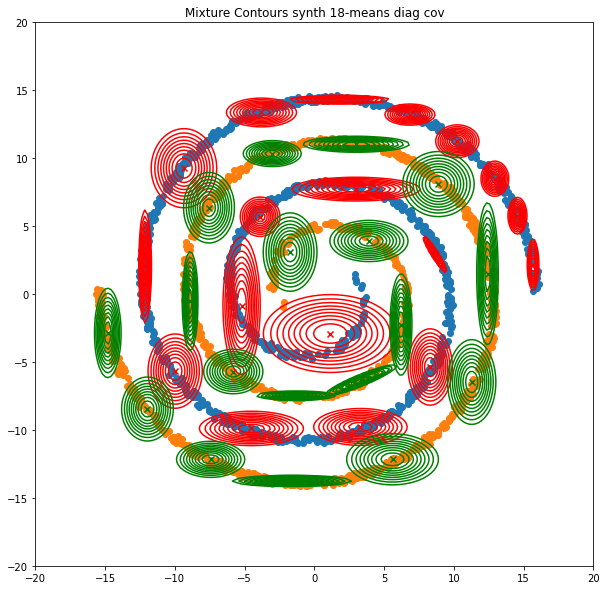

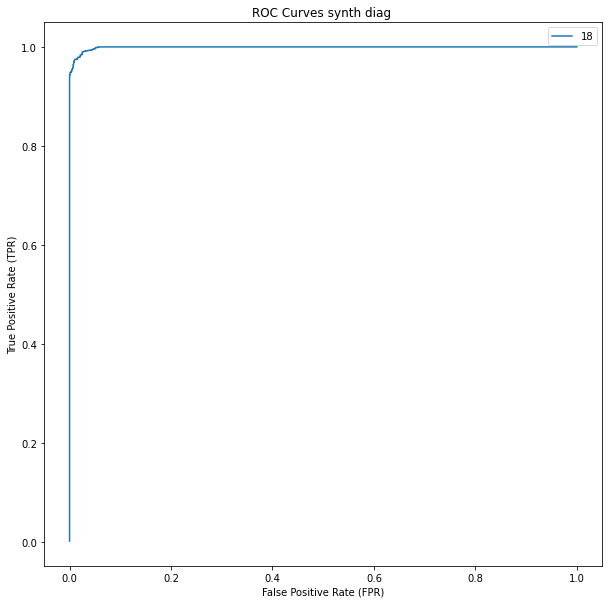

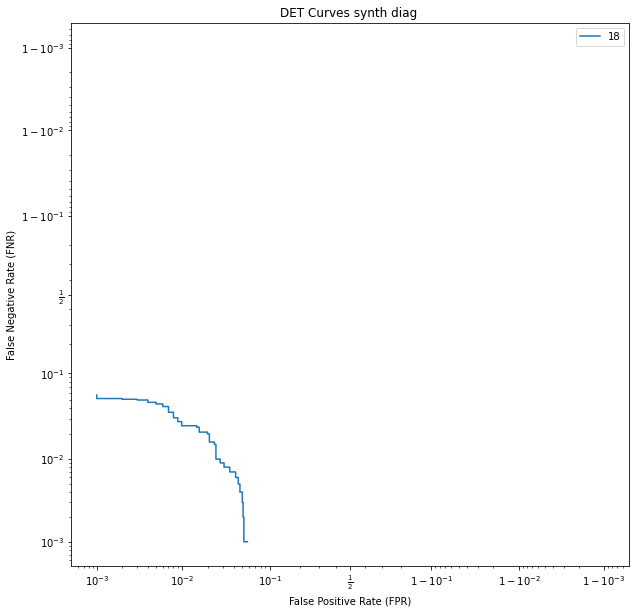

k=18
Iterations to convergence = 24
Iterations to convergence = 43
Iterations taken: 40
Iterations taken: 34
Accuracy: 0.999
Starting class 1 ...
Starting class 2 ...


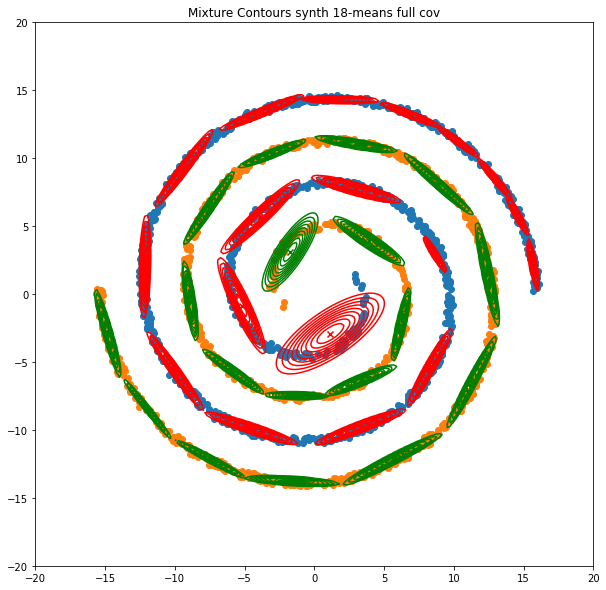

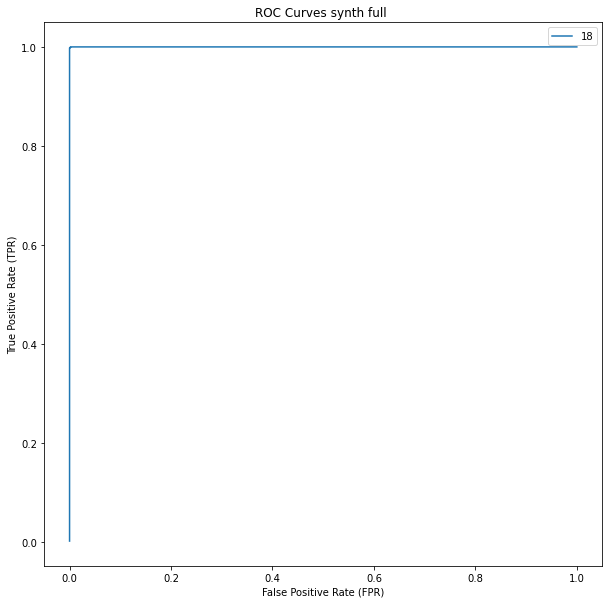

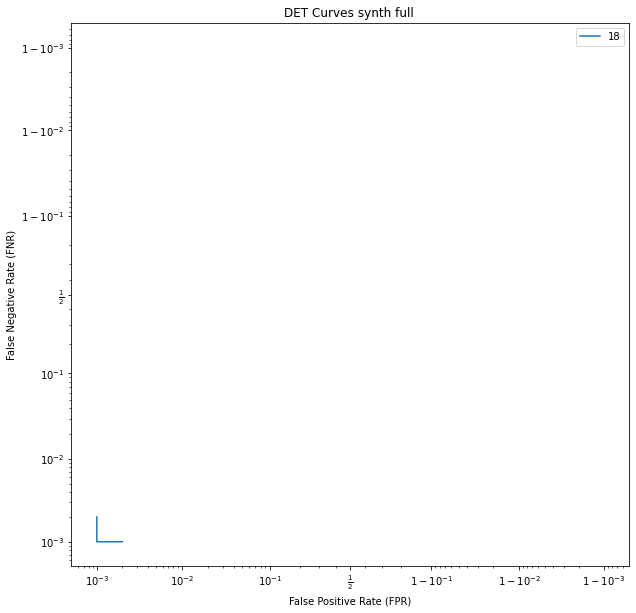

k=18
Iterations to convergence = 24
Iterations to convergence = 43
Iterations taken: 23


KeyboardInterrupt: 

In [32]:
k_range = [18]
posts_k_both_ll = {}
for iters in [10,30,50,70,90]:
    for diag in [True,False]:
        diag_str = "diag" if diag else "full"    
        acc, posts_ll = acc_post(train_data_classes,k_range=k_range,do_plot=True,diag=diag,iters=iters)
        roc_det(posts_ll, k_range, 'synth', diag_str, extra=str(iters))
        for k_id in k_range:
            posts_k_both_ll[str(k_id)+'_'+diag_str] = posts_ll[k_id]

cases = [str(k_id)+'_'+'full' for k_id in k_range] + [str(k_id)+'_'+'diag' for k_id in k_range]
roc_det(posts_k_both_ll, cases, 'synth', 'compare', extra=str(iters))

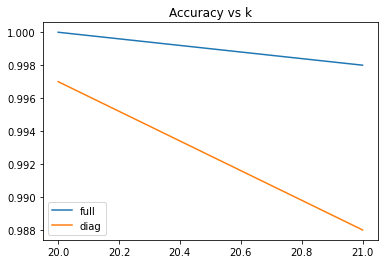

In [56]:
# acc vs k

acc_full_lst = [acc[k] for k in k_range]
acc_diag_lst = [acc_diag[k] for k in k_range]

plt.figure()
plt.plot(k_range, acc_full_lst)
plt.plot(k_range, acc_diag_lst)
plt.legend(['full','diag'])
plt.title("Accuracy vs k")
plt.savefig(f"acc_vs_k_synth_full_and_diag.png")
plt.show()


In [62]:
im_keys = ["coast","forest","highway","mountain","opencountry"]
im_train_data = {}
im_dev_data = {}

for cl in im_keys:
    im_train_list = sorted(os.listdir(f"Features/{cl}/train/"))
    im_train_data[cl] = np.array([np.loadtxt(f"Features/{cl}/train/{i}") for i in im_train_list])
    
    im_dev_list = sorted(os.listdir(f"Features/{cl}/dev/"))
    im_dev_data[cl] = np.array([np.loadtxt(f"Features/{cl}/dev/{i}") for i in im_dev_list])

In [63]:
def find_k_clusters(dataset,k, diag=False,iters=30):
    cls = dataset.keys()
    means_kmeans_d = {}
    allots_kmeans_d = {}
    for cl in cls:
        means_here,allotments_here = k_means(dataset[cl], k,iters=iters)
        means_kmeans_d[cl], allots_kmeans_d[cl] = means_here, allotments_here
    means_em_d = {}
    covs_em_d = {}
    pi_em_d = {}
    
    for cl in cls:
        dest_shape = [-1,dataset[cl].shape[-1]]
        dataset_here = np.reshape(dataset[cl], dest_shape)
        print(f"Dataset dest_shape: {dataset_here.shape}")
        means_em_d[cl], covs_em_d[cl], pi_em_d[cl] = EM(dataset_here,means_kmeans_d[cl],allots_kmeans_d[cl], mean_update=False, diag=diag, iters=iters)
    return means_em_d,covs_em_d,pi_em_d

In [8]:
train_data_classes.shape

(2, 1250, 3)

In [9]:
means_em_d = [{}]*5
for i,iters in enumerate([10,30,50,70,90]):
    means_em_d[i], covs_em_d[i], pi_em_d[i] = find_k_clusters(train_data_classes[:,:,:-1], 15, iters=iters)

NameError: name 'find_k_clusters' is not defined

In [64]:
means_em_d, covs_em_d, pi_em_d = find_k_clusters(im_train_data, 15)

Iterations to convergence = 72
Iterations to convergence = 74
Iterations to convergence = 67
Iterations to convergence = 58
Iterations to convergence = 70
Dataset dest_shape: (9036, 23)
Iterations taken: 9
Dataset dest_shape: (8244, 23)
Iterations taken: 4
Dataset dest_shape: (6552, 23)
Iterations taken: 17
Dataset dest_shape: (9396, 23)
Iterations taken: 8
Dataset dest_shape: (10332, 23)
Iterations taken: 9


In [65]:
# Predict dev

def calc_acc(dev,means_em_d,covs_em_d,pi_em_d):
    correct = 0
    total = 0
    classes = sorted(list(dev.keys()))
    posts_list = []
    for cl in classes:
        for i in range(dev[cl].shape[0]):
            # print(f"dev cl i shape: {dev[cl][i].shape}")
            posts_all_bl = []
            pred_cl_all_bl = []
            for j in range(dev[cl][i].shape[0]):
                pred_cl_block, posts_block = predict(dev[cl][i][j], means_em_d, covs_em_d, pi_em_d)
                posts_all_bl.append(posts_block)
                pred_cl_all_bl.append(pred_cl_block)
            # pred_cl, posts = predict(dev[cl][i],means_em_d, covs_em_d, pi_em_d)
            cl_probabs = {cli:1 for cli in classes}
            for j in range(dev[cl][i].shape[0]):
                posts_block = posts_all_bl[j]
                for cand_cl in posts_block.keys():
                    cl_probabs[cand_cl] *= posts_block[cand_cl]
            posts_list.extend([[cl_probabs[cand_cl], cand_cl, cl] for cand_cl in classes])
            pred_cl = max(cl_probabs, key=cl_probabs.get)
            true_cl = cl
            if pred_cl == true_cl:
                correct += 1
                print("Correct")
            else:
                print("Wrong")
            total += 1
    acc = correct/total
    print(f"Accuracy: {acc}")
    return acc, posts_list

In [66]:
acc, posts_list = calc_acc(im_dev_data, means_em_d, covs_em_d, pi_em_d)

Correct
Wrong
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Wrong
Correct
Correct
Wrong
Wrong
Wrong
Correct
Wrong
Wrong
Correct
Correct
Wrong
Correct
Correct
Correct
Correct
Correct
Wrong
Correct
Correct
Wrong
Wrong
Correct
Correct
Correct
Correct
Wrong
Correct
Correct
Correct
Correct
Correct
Wrong
Correct
Correct
Correct
Correct
Wrong
Wrong
Wrong
Wrong
Wrong
Wrong
Wrong
Wrong
Wrong
Wrong
Wrong
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Wrong
Correct
Wrong
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Correct
Wrong
Wrong
Wrong
Wrong
Wrong
Correct
Correct
Correct
Correct
Correct
Correct
Correc

[[array([2.43746313e-14]), 'coast', 'coast'], [array([5.77457203e-107]), 'forest', 'coast'], [array([2.81682808e-66]), 'highway', 'coast'], [array([1.58866726e-38]), 'mountain', 'coast'], [array([1.98268744e-37]), 'opencountry', 'coast'], [array([3.51705703e-34]), 'coast', 'coast'], [array([1.42424513e-50]), 'forest', 'coast'], [array([2.53589942e-83]), 'highway', 'coast'], [array([2.0626763e-33]), 'mountain', 'coast'], [array([1.19085091e-44]), 'opencountry', 'coast']]


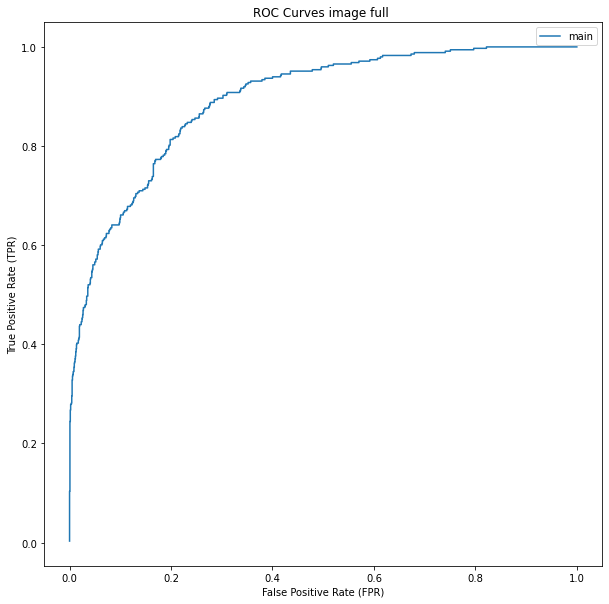

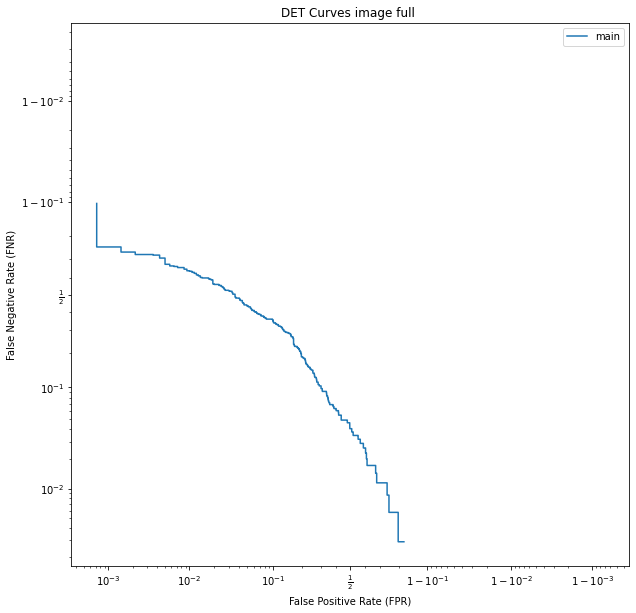

In [67]:
print(posts_list[:10])
roc_det({'main':posts_list}, ['main'], 'image', 'full')

In [69]:
do_plot = False
k_range = list(range(5,25))[::4]
acc = {}
acc_diag = {}
posts_ll_full = {}
for k in k_range:
    posts_list_full_k = []
    print(f"k={k}")
    cls_k = im_keys
    cl_to_ind = {cls_k[i]:i for i in range(len(cls_k))}
    cl_colors = ['red', 'green']
    means_kmeans_d_k = {}
    allots_kmeans_d_k = {}
    means_em_d_k, covs_em_d_k, pi_em_d_k = find_k_clusters(im_train_data, k)

    acc[k], posts_ll_full[k] = calc_acc(im_dev_data, means_em_d_k, covs_em_d_k, pi_em_d_k)

roc_det(posts_ll_full, k_range, 'image', 'full')

posts_ll_diag = {}
for k in k_range:
    print(f"k={k}")
    cls_k = im_keys
    cl_to_ind = {cls_k[i]:i for i in range(len(cls_k))}
    cl_colors = ['red', 'green']
    means_kmeans_d_k = {}
    allots_kmeans_d_k = {}
    means_em_d_k, covs_em_d_k, pi_em_d_k = find_k_clusters(im_train_data, k, diag=True)
    
    acc_diag[k], posts_ll_diag[k] = calc_acc(im_dev_data, means_em_d_k, covs_em_d_k, pi_em_d_k)

roc_det(posts_ll_diag, k_range, 'image', 'diag')

k=5
Iterations to convergence = 97
Iterations to convergence = 83
Iterations to convergence = 47
Iterations to convergence = 49
Iterations to convergence = 54
Dataset dest_shape: (9036, 23)
Iterations taken: 2
Dataset dest_shape: (8244, 23)
Iterations taken: 6
Dataset dest_shape: (6552, 23)


KeyboardInterrupt: 

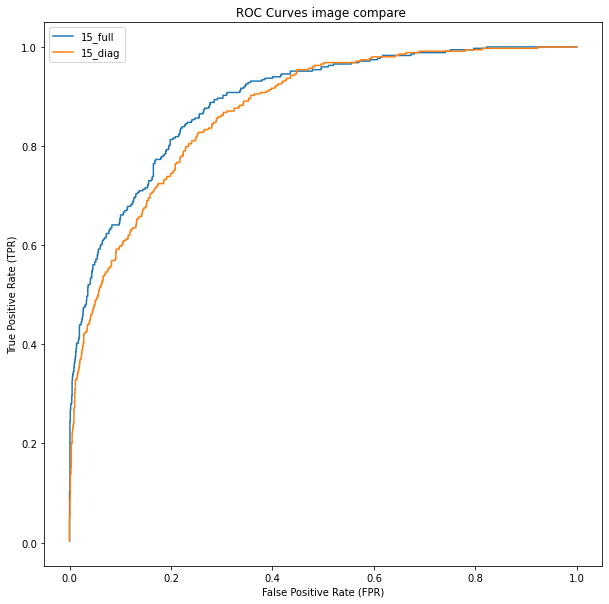

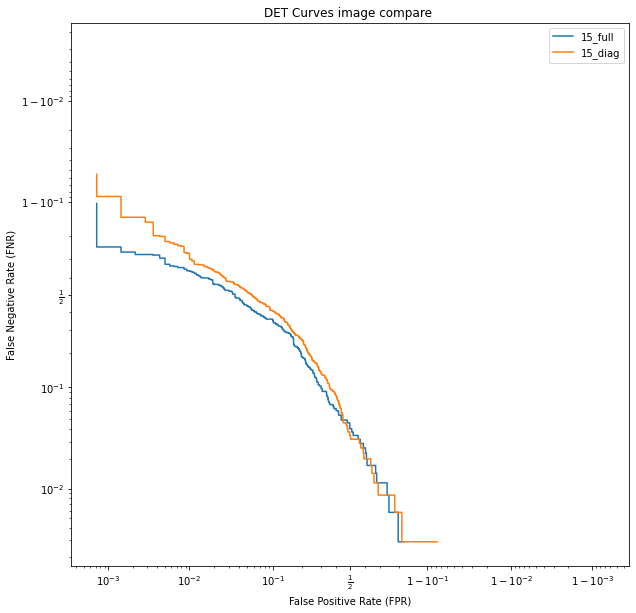

In [82]:
posts_k_both_ll = {}
for k_id in k_range:
    posts_k_both_ll[str(k_id)+'_'+'full'] = posts_ll_full[k]
    posts_k_both_ll[str(k_id)+'_'+'diag'] = posts_ll_diag[k]

cases = [str(k_id)+'_'+'full' for k_id in k_range] + [str(k_id)+'_'+'diag' for k_id in k_range]
roc_det(posts_k_both_ll, cases, 'image', 'compare')

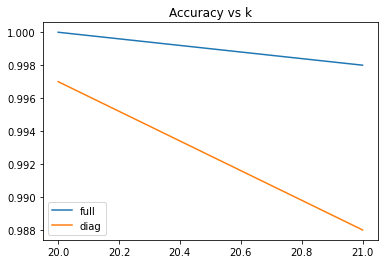

In [61]:
acc_full_lst = [acc[k] for k in k_range]
acc_diag_lst = [acc_diag[k] for k in k_range]

plt.figure()
plt.plot(k_range, acc_full_lst)
plt.plot(k_range, acc_diag_lst)
plt.legend(['full','diag'])
plt.title("Accuracy vs k")
plt.savefig(f"acc_vs_k_synth_full_and_diag.png")
plt.show()

In [ ]:
def normalize(train_data, dev_data):
    
    data = np.empty((0, train_data[0].shape[1]))
    for classes in train_data:
        data = np.r_[data, classes]
    mean = np.mean(data, axis=0)
    range = np.amax(data, axis=0)-np.amin(data, axis=0)
    normalized_test = []
    normalized_dev = []
    for data in train_data:
        normalized_data = (data - mean) / range
        normalized_test.append(normalized_data)
    for data in dev_data:
        normalized_data = (data - mean) / range
        normalized_dev.append(normalized_data)
    return normalized_test, normalized_dev

def normalize_data(train_feats, dev_feats):
    # subtract mean, divide 
    pass

In [ ]:
# TODOs

# TODO Main -------------------------------------

# TODO Image: Normalise the dataset
# TODO Change from muno.pdf() to own gaussian <<< DONE >>>
# TODO Plot Acc vs k for diag and non-diag << DONE >>
# TODO Image and Synthetic: K Means iterations, EM iterations
# TODO DTW HMM Report with Plots etc
# TODO Tables with result values
# TODO Result points
# TODO Refactor Code

# TODO Optionals --------------------------------

# TODO UBM GMM
# TODO Connected HMM
# TODO Vectorize
# TODO Experiment with symbol vs state count